# Using ColPali with Qdrant to index and search a UFO document dataset

Based on: https://danielvanstrien.xyz/posts/post-with-code/colpali-qdrant/2024-10-02_using_colpali_with_qdrant.html

In [1]:
from rich.console import Console
from rich_theme import custom_theme

# Create a console with the dark theme
console = Console(theme=custom_theme)

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
## Loading scanned documents dataset

In [4]:
import os
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

In [5]:
dataset = load_dataset("davanstrien/ufo-ColPali", split="train")

In [6]:
console.print(dataset)

Dataset({
    features: ['image', 'raw_queries', 'broad_topical_query', 'broad_topical_explanation', 'specific_detail_query',
'specific_detail_explanation', 'visual_element_query', 'visual_element_explanation', 'parsed_into_json'],
    num_rows: 2243
})

In [7]:
# Trim the dataset to the first 50 rows
dataset = dataset.select(range(50))

# Verify the new size
console.print(f"Dataset size after trimming: {len(dataset)}")



Dataset size after trimming: 50

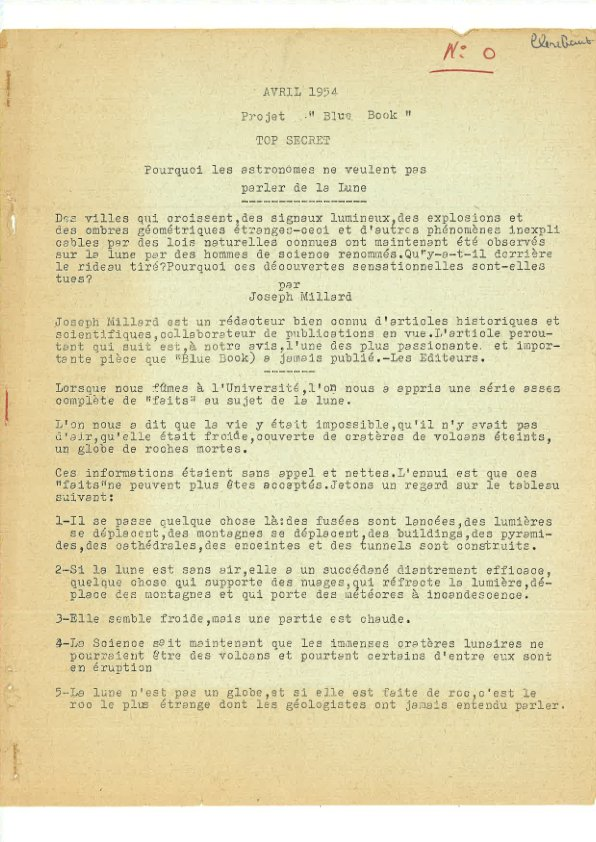

In [8]:
dataset[0]["image"]



## Loading the documents into a vector database

In [9]:
qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage

### Using a multi modal encoding model

Since the documents are not simple text documents, we need an encoder that can create embedding of the scanned text document. The [davanstrien/finetune_colpali_v1_2-ufo-4bit](https://huggingface.co/davanstrien/finetune_colpali_v1_2-ufo-4bit) model was pre-trained on that data, as you can learn on the model page above.

In [10]:
from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "davanstrien/finetune_colpali_v1_2-ufo-4bit"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
sample_image = dataset[0]["image"]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [12]:
console.print(sample_embedding)

tensor([[[ 0.0248, -0.0056,  0.1426,  ...,  0.0166, -0.0811, -0.1729],
         [-0.0334,  0.1768,  0.1748,  ...,  0.0239, -0.1143, -0.1201],
         [ 0.0369,  0.1553,  0.0947,  ..., -0.0659, -0.0173, -0.0361],
         ...,
         [-0.0664, -0.0251,  0.1602,  ..., -0.0806,  0.0820,  0.0449],
         [-0.1309,  0.1035,  0.1758,  ...,  0.0356, -0.0537, -0.0566],
         [-0.0757,  0.1084,  0.2197,  ...,  0.0184, -0.0669, -0.0850]]],
       device='mps:0', dtype=torch.bfloat16)

In [13]:
from rich.table import Table

table = Table(title="Document Embedding")
table.add_column("Documents", style="cyan", no_wrap=True)
table.add_column("Tokens", style="bright_yellow")
table.add_column("Vector Size", style="green")

table.add_row(
    str(sample_embedding.shape[0]), 
    str(sample_embedding.shape[1]), 
    str(sample_embedding.shape[2])
)

console.print(table)

         Document Embedding         
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Documents ┃ Tokens ┃ Vector Size ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1         │ 1030   │ 128         │
└───────────┴────────┴─────────────┘

In [14]:
vector_size = sample_embedding.shape[2]

Adjusting PyTorch default paramters to allow running it on a laptop with limited memory.

In [15]:
import os

# Set the environment variable
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.9'

# Print confirmation message
console.print(f"PYTORCH_MPS_HIGH_WATERMARK_RATIO set to: {os.environ.get('PYTORCH_MPS_HIGH_WATERMARK_RATIO', 'Not set')}")


PYTORCH_MPS_HIGH_WATERMARK_RATIO set to: 0.9

In [16]:
collection_name = "ufo"

## Using Multi-Vector configuration

We need to define several different parameters for the collection. One of these is the VectorParams. These let Qdrant know what size of vectors we want to store and what similarity metrics we want to use for comparing vectors. In this case, we also pass in a `MultivVectorConfig`, which tells Qdrant that we are storing multivectors.

In [17]:
multi_vector_params = models.VectorParams(
    size=vector_size,
    distance=models.Distance.COSINE,
    multivector_config=models.MultiVectorConfig(
        comparator=models.MultiVectorComparator.MAX_SIM
    ),
)

In [18]:
console.print(multi_vector_params)

VectorParams(
    size=128,
    distance=<Distance.COSINE: 'Cosine'>,
    hnsw_config=None,
    quantization_config=None,
    on_disk=None,
    datatype=None,
    multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
)

## Reducing vector memory using Quantization

We can define a `ScalarQuantizationConfig` and pass it when creating the collection. On the server side, Qdrant will convert the vectors to 8-bit integers, reducing the memory footprint and speeding up the search process. You can also switch on or off the `always_ram` parameter, keeping the vectors in RAM. This will increase performance at the cost of memory usage.

In [19]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8,
    quantile=0.99,
    always_ram=False,
)

In [20]:
qdrant_client.recreate_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=scalar_quant,
        ),
    ),
)

True

We define a helper function to upload points to Qdrant via the client. We use the stamina library to enable retries in case of network issues 

In [21]:
import stamina

@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

We will now upload the vectors to qdrant. We do this by creating batches of data, passing it through the ColPali model and then adding the embeddings to a Qdrant `PointStruct`. 

In [22]:
batch_size = 2  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )
        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        # clown level error handling here 🤡
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 100%|██████████| 50/50 [14:02<00:00, 16.85s/it]

Indexing complete!


If you had the indexing off during the upload you can trigger an index by setting a lower indexing threshold.

In [23]:
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

False

In [24]:
console.print(
    qdrant_client
    .get_collection(collection_name)
)

CollectionInfo(
    status=<CollectionStatus.GREEN: 'green'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=None,
    indexed_vectors_count=0,
    points_count=50,
    segments_count=1,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=128,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=ScalarQuantization(
                    scalar=ScalarQuantizationConfig(
                        type=<ScalarType.INT8: 'int8'>,
                        quantile=0.99,
                        always_ram=False
                    )
                ),
                on_disk=None,
                datatype=None,
                multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
            ),
            shard_number=None,
            sharding_method=None,
            replication_factor=None,
            write_consistency_factor=None,
            read_fan_out_factor=None,
            on_disk_payload=None,
            sparse_vectors=None
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=None,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=20000,
            flush_interval_sec=5,
            max_optimization_threads=1
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None
    ),
    payload_schema={}
)

In [25]:
console.print(
    qdrant_client
    .scroll(
        collection_name=collection_name, 
        limit=10
    )
)

(
    [
        Record(id=0, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=1, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=2, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=3, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=4, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=5, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=6, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=7, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=8, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
        Record(id=9, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None)
    ],
    10
)

## Query the scanned documents vector database

In [26]:
query_text = "top secret"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
console.print(query_embedding)

tensor([[[ 0.1494, -0.0242,  0.0898,  ..., -0.0164, -0.0786, -0.0311],
         [-0.1055, -0.1108,  0.0508,  ..., -0.0250, -0.0859,  0.0806],
         [-0.1240, -0.0190,  0.0620,  ..., -0.0254, -0.0002, -0.0283],
         ...,
         [-0.0569,  0.0386,  0.0493,  ...,  0.0102,  0.0447,  0.0444],
         [-0.0625,  0.0349,  0.0452,  ...,  0.0048,  0.0483,  0.0253],
         [-0.0618,  0.0552,  0.0601,  ..., -0.0088,  0.0452,  0.0231]]],
       device='mps:0', dtype=torch.bfloat16)

In [27]:
table = Table(title="Query Embedding")
table.add_column("Query Text", style="bright_yellow")
table.add_column("Tokens", style="bright_yellow")
table.add_column("Vector Size", style="green")

table.add_row(
    query_text,
    str(query_embedding.shape[1]), 
    str(query_embedding.shape[2]), 
)

console.print(table)

           Query Embedding           
┏━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Query Text ┃ Tokens ┃ Vector Size ┃
┡━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━┩
│ top secret │ 16     │ 128         │
└────────────┴────────┴─────────────┘

In [28]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [29]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, 
    query=multivector_query, 
    limit=10, 
    timeout=60,
)

console.print(search_result.points)

[
    ScoredPoint(
        id=0,
        version=0,
        score=11.076677105362005,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=47,
        version=0,
        score=8.396739464312947,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=40,
        version=0,
        score=6.891255772613538,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=11,
        version=0,
        score=6.304188724953814,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=21,
        version=0,
        score=6.285428622904016,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=43,
        version=0,
        score=5.935927437864479,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=3,
        version=0,
        score=5.760776241326832,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=34,
        version=0,
        score=5.715908164593253,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=35,
        version=0,
        score=5.679006973411257,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    ),
    ScoredPoint(
        id=17,
        version=0,
        score=5.5845919443924465,
        payload={'source': 'internet archive'},
        vector=None,
        shard_key=None,
        order_value=None
    )
]

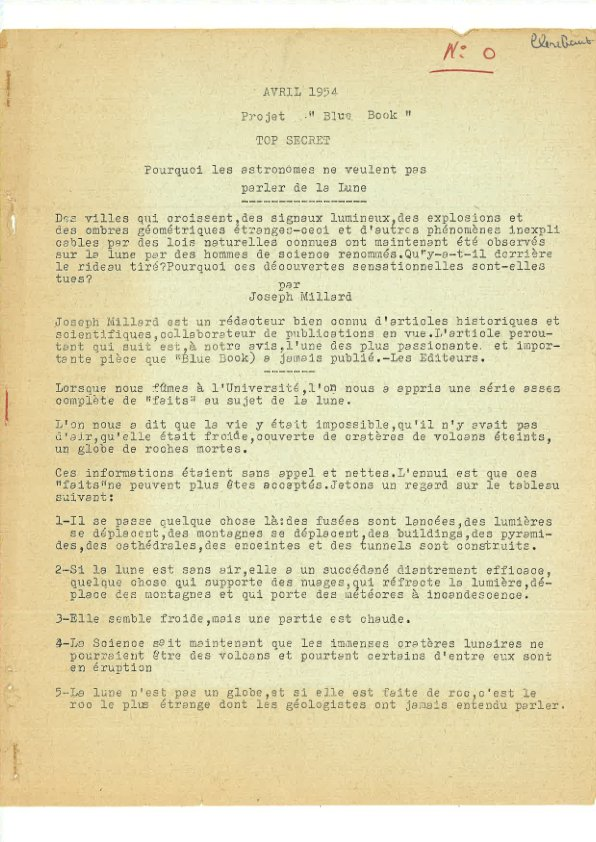

In [30]:
idx = search_result.points[0].id
dataset[idx]["image"]

In [31]:
def search_images_by_text(query_text, top_k=5):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, 
        query=multivector_query, 
        limit=top_k
    )

    return search_result


# Example usage
query_text = "declassified data"
results = search_images_by_text(query_text)

for result in results.points:
    console.print(result)

ScoredPoint(
    id=40,
    version=0,
    score=10.961262547927271,
    payload={'source': 'internet archive'},
    vector=None,
    shard_key=None,
    order_value=None
)

ScoredPoint(
    id=32,
    version=0,
    score=7.38555458406326,
    payload={'source': 'internet archive'},
    vector=None,
    shard_key=None,
    order_value=None
)

ScoredPoint(
    id=31,
    version=0,
    score=7.226121137821519,
    payload={'source': 'internet archive'},
    vector=None,
    shard_key=None,
    order_value=None
)

ScoredPoint(
    id=24,
    version=0,
    score=7.191567643379738,
    payload={'source': 'internet archive'},
    vector=None,
    shard_key=None,
    order_value=None
)

ScoredPoint(
    id=27,
    version=0,
    score=6.900743302996678,
    payload={'source': 'internet archive'},
    vector=None,
    shard_key=None,
    order_value=None
)

and in this case, we can also return the images from the dataset

In [32]:
def search_by_text_and_return_images(query_text, top_k=5):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return dataset.select(row_ids)

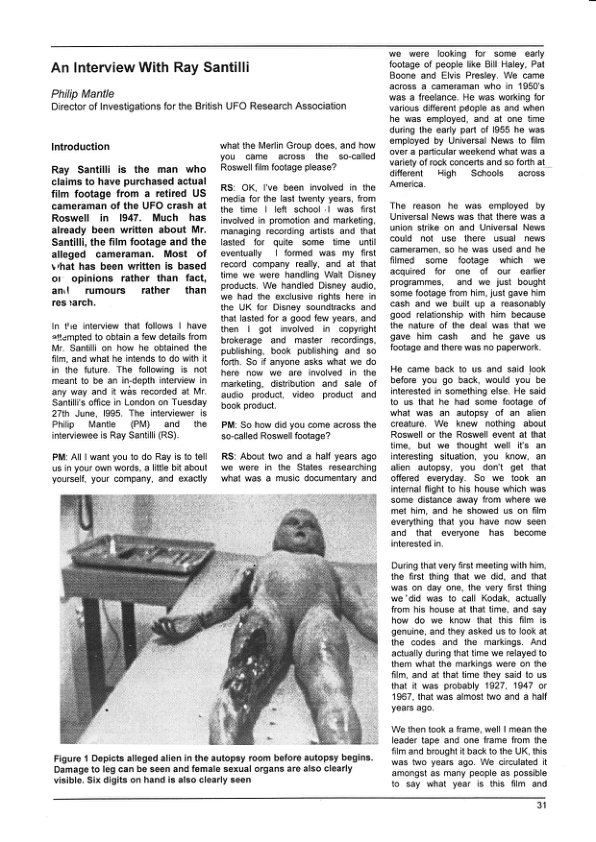

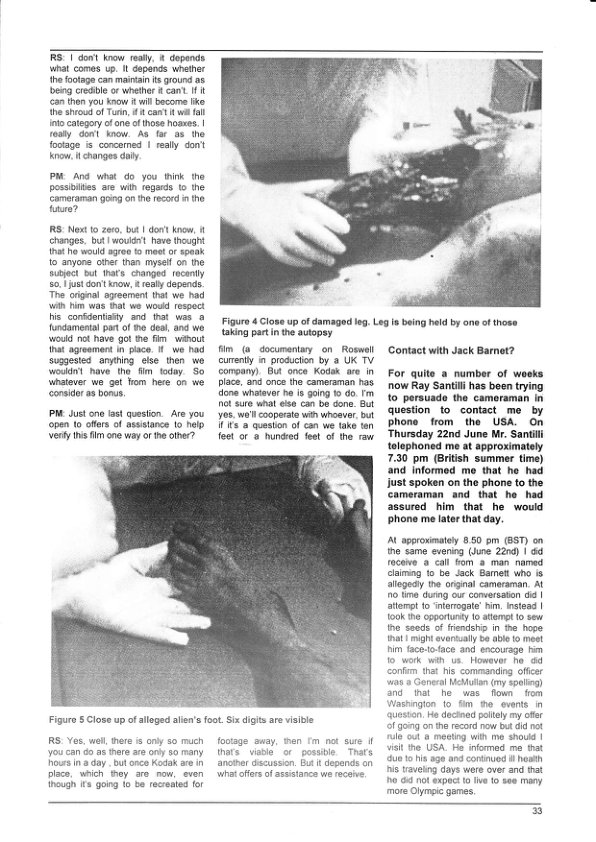

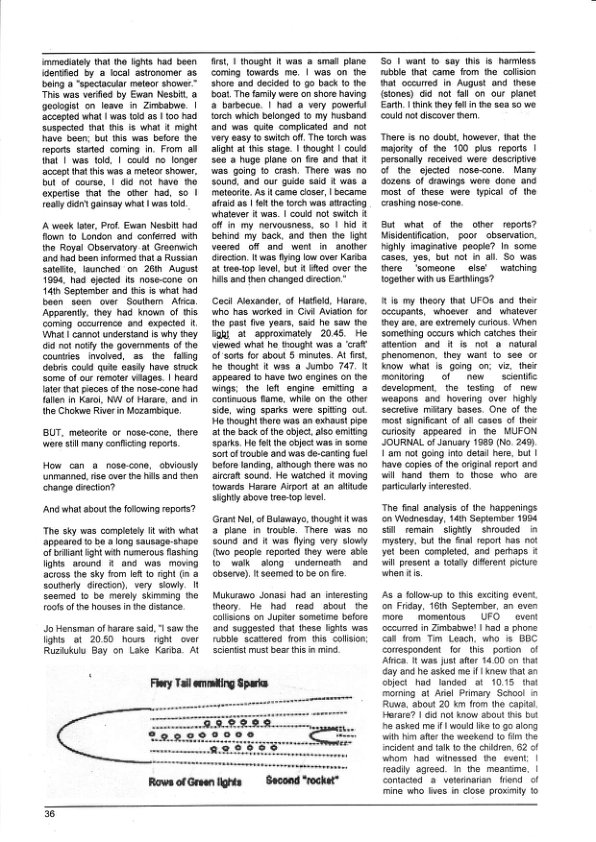

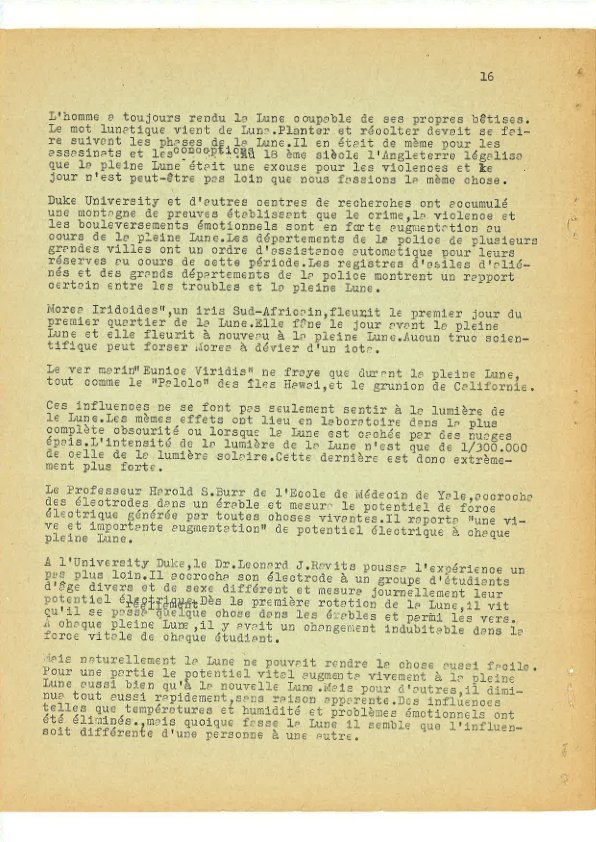

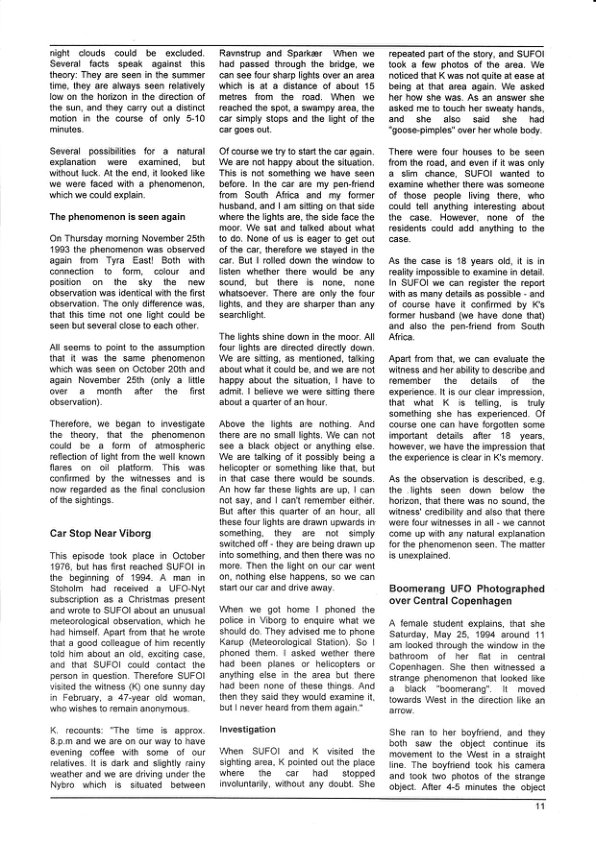

In [33]:
results_ds = search_by_text_and_return_images("Roswell")

for row in results_ds:
    # display image
    display(row["image"])